# 16-2. 이상 데이터 분석 및 처리

In [ ]:
# 라이브러리 불러오기 
import pandas as pd 

# 데이터 불러오기
user_data = pd.read_csv("/Users/kenny_jung/aiffel/data/user_data.csv")

# 데이터의 상위 5번째 행까지 출력
user_data.head()

In [ ]:
from scipy import stats
import numpy as np

In [ ]:
# Z-score 계산 
z_scores = stats.zscore(user_data.iloc[:, 1:], axis=0)  

# Z-score 절대값 계산
z_scores = np.abs(z_scores)

# Z-score 출력
z_scores

In [ ]:
# 임계값(threshold) 설정
threshold = 3

# z-score 기준으로 이상치를 찾아서 outlier 컬럼에 이상치 여부 기입 (0: 정상, 1:이상치)
user_data['outlier'] = (z_scores > threshold).any(axis=1).astype(int)
user_data.head()

In [ ]:
# 시각화에 필요한 라이브러리 불러오기
import matplotlib.pyplot as plt 

# user_data['outlier']을 활용하여 이상치 여부에 따른 확률 계산
# value_counts()는 열의 고윳값의 개수를 반환하지만 normalize=True를 사용하면 열에 있는 값의 개수 비율(상대적 빈도)을 반환함
outlier_percentage = pd.value_counts(user_data['outlier'], normalize=True) * 100

# 시각화 자료 크기 조정
plt.figure(figsize=(3, 4))

# outlier_percentage라는 데이터로 bar chart 시각화
# x축 값을 0과 1로 지정
bars = plt.bar(['0', '1'], outlier_percentage)

# 퍼센트(%) 표시
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval/2, f'{yval:.2f}%', fontsize=10, va='center', ha='center')

plt.title('Normal(0) vs Outlier(1)') # 표 제목
plt.yticks(ticks=np.arange(0, 101, 10)) # y축 표기 (0~100까지 10단위로 증가)
plt.ylabel('Percentage (%)') # y축 범례
plt.xlabel('Outlier') # x축 범례
plt.show() # 출력

In [ ]:
# 정상 데이터만 필터링 
user_data = user_data[user_data['outlier'] == 0] 

# outlier 컬럼 삭제 
user_data = user_data.drop(columns=['outlier'])

# DataFrame의 인덱스를 리셋하고, 이전 인덱스를 컬럼으로 추가하지 않음
user_data.reset_index(inplace=True, drop=True)
user_data.head()

# 16-3. 변수 간 상관관계 분석

In [ ]:
# 시각화 라이브러리 불러오기
import seaborn as sns  

# 'CustomerID' 열을 제외(drop)하고 상관 관계 행렬 계산(corr())
corr = user_data.drop(columns=['CustomerID']).corr()

# 행렬이 대각선을 기준으로 대칭이기 때문에 하단만 표시하기 위한 마스크 생성
mask = np.zeros_like(corr) # np.zeros_like()는 0으로 가득찬 array 생성, 크기는 corr와 동일   
mask[np.triu_indices_from(mask, k=1)] = True # array의 대각선 영역과 그 윗 부분에 True가 들어가도록 설정

# 히트맵 그리기
plt.figure(figsize=(8, 6))
sns.heatmap(corr, mask=mask, cmap='Greys', annot=True, fmt='.2f')
plt.show()

# 16-4. 피처(feature) 스케일링

In [ ]:
# Standard Scaler 불러오기 
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [ ]:
# 원본 데이터에 영향을 주지 않기 위해 복사 
data = user_data.copy()

# CustomerID를 제외한 데이터에 스케일링 적용
columns_list = data.iloc[:, 1:].columns # iloc: 데이터 특정 값 추출, columns: 데이터프레임의 열 이름 조회 
data[columns_list] = scaler.fit_transform(data[columns_list])

In [ ]:
# 스케일링 된 데이터 출력
data.head()

# 16-5. 차원축소

In [ ]:
# PCA 불러오기  
from sklearn.decomposition import PCA

# CustomerID를 인덱스로 지정  
data.set_index('CustomerID', inplace=True)

# PCA 적용
pca = PCA().fit(data)

In [ ]:
# Explained Variance의 누적합 계산  
explained_variance_ratio = pca.explained_variance_ratio_ # explained_variance_ratio_: Explained Variance 비율을 계산해 주는 함수
cumulative_explained_variance = np.cumsum(explained_variance_ratio) # cumsum: 각 원소의 누적합을 계산하는 함수

In [ ]:
plt.figure(figsize=(15, 8)) 

# 각 성분의 설명된 분포에 대한 막대 그래프
barplot = sns.barplot(x=list(range(1, len(cumulative_explained_variance) + 1)), y=explained_variance_ratio, alpha=0.8)

# 누적 분포에 대한 선 그래프
lineplot, = plt.plot(range(0, len(cumulative_explained_variance)), cumulative_explained_variance, marker='o', linestyle='--', linewidth=2)

# 레이블과 제목 설정
plt.xlabel('Number of Components', fontsize=14)
plt.ylabel('Explained Variance', fontsize=14)
plt.title('Cumulative Variance vs. Number of Components', fontsize=18)

# 눈금 및 범례 사용자 정의
plt.xticks(range(0, len(cumulative_explained_variance)))
plt.legend(handles=[barplot.patches[0], lineplot],
           labels=['Explained Variance', 'Cumulative Explained Variance'])  

# 두 그래프의 분산 값 표시
x_offset = -0.3
y_offset = 0.01
for i, (ev_ratio, cum_ev_ratio) in enumerate(zip(explained_variance_ratio, cumulative_explained_variance)):
    plt.text(i, ev_ratio, f"{ev_ratio:.2f}", ha="center", va="bottom", fontsize=10)
    if i > 0:
        plt.text(i + x_offset, cum_ev_ratio + y_offset, f"{cum_ev_ratio:.2f}", ha="center", va="bottom", fontsize=10)

plt.grid(axis='both')   
plt.show()

In [ ]:
# 6개의 주성분을 유지하는 PCA 선언 
pca = PCA(n_components=6)

# 기존 data를 pca에 fit_transform
data_pca = pca.fit_transform(data)

# 압축된 데이터 셋 생성
data_pca = pd.DataFrame(data_pca, columns=['PC'+str(i+1) for i in range(pca.n_components_)])

# 인덱스로 빼 두었던 CustomerID 다시 추가
data_pca.index = data.index

In [ ]:
data_pca.head()

# 16-6. K-Means 클러스터링

In [ ]:
from sklearn.cluster import KMeans
from collections import Counter

# k=3개의 클러스터로 K-Means 클러스터링 적용
kmeans = KMeans(n_clusters=3, init='k-means++', n_init=10, max_iter=100, random_state=0)
kmeans.fit(data_pca)

# 각 클러스터의 빈도수 구하기
cluster_frequencies = Counter(kmeans.labels_) 

# 빈도수에 기반하여 이전 레이블에서 새 레이블로의 매핑 생성
label_mapping = {label: new_label for new_label, (label, _) in 
                 enumerate(cluster_frequencies.most_common())}

# 매핑을 적용하여 새 레이블 얻기
new_labels = np.array([label_mapping[label] for label in kmeans.labels_])

# 원래 데이터셋에 새 클러스터 레이블 추가
user_data['cluster'] = new_labels

# PCA 버전의 데이터셋에 새 클러스터 레이블 추가
data_pca['cluster'] = new_labels

In [ ]:
# K-Means 분류된 결과 보기
user_data.head()

In [ ]:
# 각 군집별로 몇 명의 고객이 있는지 확인
user_data.value_counts('cluster')

# 16-7. 시각화 및 결과 분석

In [ ]:
# 각 클러스터 별 데이터 분리 
cluster_0 = data_pca[data_pca['cluster'] == 0]
cluster_1 = data_pca[data_pca['cluster'] == 1]
cluster_2 = data_pca[data_pca['cluster'] == 2]


# 클러스터 별 시각화
plt.scatter(cluster_0['PC1'], cluster_0['PC2'], color = 'orange', alpha = 0.7, label = 'Group1')
plt.scatter(cluster_1['PC1'], cluster_1['PC2'], color = 'red', alpha = 0.7, label = 'Group2')
plt.scatter(cluster_2['PC1'], cluster_2['PC2'], color = 'green', alpha = 0.7, label = 'Group3')

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.show()

In [ ]:
#pip install plotly==5.18.0

In [ ]:
#pip install nbformat

In [ ]:
# 색상 지정 
colors = ['red', 'blue', 'green']

# 각 클러스터별 데이터 분리
cluster_0 = data_pca[data_pca['cluster'] == 0]
cluster_1 = data_pca[data_pca['cluster'] == 1]
cluster_2 = data_pca[data_pca['cluster'] == 2]

# 3D Scatter Plot 생성
import plotly.graph_objects as go
fig = go.Figure()

# 각 클러스터별 데이터 표기 
fig.add_trace(go.Scatter3d(x=cluster_0['PC1'], y=cluster_0['PC2'], z=cluster_0['PC3'], 
                           mode='markers', marker=dict(color=colors[0], size=5, opacity=0.4), name='Group 1'))
fig.add_trace(go.Scatter3d(x=cluster_1['PC1'], y=cluster_1['PC2'], z=cluster_1['PC3'], 
                           mode='markers', marker=dict(color=colors[1], size=5, opacity=0.4), name='Group 2'))
fig.add_trace(go.Scatter3d(x=cluster_2['PC1'], y=cluster_2['PC2'], z=cluster_2['PC3'], 
                           mode='markers', marker=dict(color=colors[2], size=5, opacity=0.4), name='Group 3'))

# 범례 및 제목 영역 설정
fig.update_layout(
    title=dict(text='3D Visualization of Customer Clusters in PCA Space', x=0.5),
    scene=dict(
        xaxis=dict(backgroundcolor="grey", gridcolor='white', title='PC1'),
        yaxis=dict(backgroundcolor="grey", gridcolor='white', title='PC2'),
        zaxis=dict(backgroundcolor="grey", gridcolor='white', title='PC3'),
    ),
    width=900,
    height=800
)

fig.show()

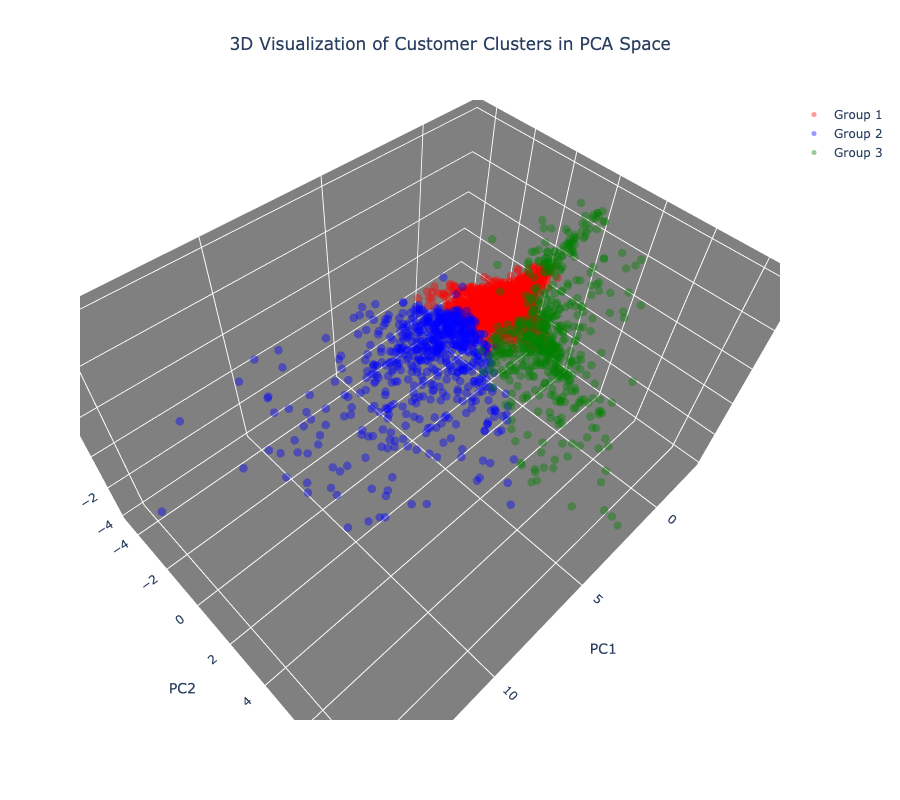

In [ ]:
group1 = user_data[user_data['cluster'] == 0]
group2 = user_data[user_data['cluster'] == 1]
group3 = user_data[user_data['cluster'] == 2]

In [ ]:
group1.describe()

In [ ]:
group2.describe()

In [ ]:
group3.describe()

## R: G2 M26/D38 > G3 M78/D88 > G1 M109/D104 (based on recency)
## F: G2 M11/D6 > G3 M5/D3 > G1 M2/D2 (based on purchase_cnt)
## M: G2 M4094/D2832 > G3 M849/D726 > G1 666/D605 (based on user_total)

# ChatGPT 응답

Group 1
이 그룹은 평균 구매 횟수가 적은 것으로 보입니다. 평균 구매 간격도 높으며, 구매 취소 비율이 0인 것으로 보아 매우 안정적인 구매 패턴을 가지고 있을 가능성이 있습니다.

Group 2
이 그룹은 평균적으로 더 많은 구매를 하며, 구매 간격이 Group 1에 비해 짧습니다. 또한, 최대 구매 횟수가 가장 높은 그룹으로, 이는 몇몇 고객이 매우 높은 구매 빈도를 보인다는 것을 의미할 수 있습니다.

Group 3
이 그룹은 구매 횟수가 적고, 평균 구매 간격이 긴 것으로 나타나, 이들은 아마도 비정기적인 구매자일 수 있습니다. 또한, 평균 구매 간격이 음수로 나타나는 이상치를 확인해야 합니다. 이는 데이터 오류일 가능성이 높으며, 데이터 클리닝 작업이 필요할 수 있습니다.

Group 1 (자주 구매하고 최근에 구매한 활동적인 고객)
리워드 프로그램: 이 그룹의 고객들은 높은 구매 빈도와 최근 구매 기록을 가지고 있으므로, 포인트 기반의 리워드 프로그램을 통해 충성도
를 높일 수 있습니다. 구매 횟수나 지출 금액에 따라 포인트를 적립하게 하여, 일정 포인트가 쌓이면 할인 혜택이나 특별 선물을 제공하는 방식이 효과적일 수 있습니다.

개인화 마케팅: 이들의 구매 패턴과 선호도를 분석하여 개인화된 추천을 제공합니다. 이메일 마케팅, SNS 광고 등을 통해 고객이 관심을 가질 만한 상품을 추천하는 것이 좋습니다.

Group 2 (높은 지출을 하지만 최근 구매가 적은 고객)
리엔게이지먼트 캠페인: 이 그룹은 과거에는 높은 지출을 했지만 최근에는 구매 빈도가 낮아졌습니다. 이들을 다시 유입시키기 위한 이메일 캠페인이나 특별 프로모션을 진행할 수 있습니다.

고객 피드백: 이 그룹에 속한

고객들이 왜 구매 빈도가 줄었는지 이해하기 위해 설문조사를 실시하거나 피드백을 요청할 수 있습니다. 이를 통해 서비스 개선에 필요한 인사이트를 얻을 수 있습니다.

Group 3 (구매 취소가 높은 고객)
서비스 개선: 취소 비율이 높은 이유를 분석하고, 제품이나 서비스의 문제점을 해결해야 합니다. 고객 서비스 팀을 강화하고, 반품 정책을 개선하는 등의 조치가 필요합니다.

신뢰 회복 프로그램: 이들에게 샘플 제품을 제공하거나, 맞춤형 할인을 제공하여 다시 한 번 시도해볼 기회를 제공합니다. 또한, 고객 서비스의 질을 높여 신뢰를 회복할 수 있는 커뮤니케이션을 강화해야 합니다.